# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
WEIGHTS = '/home/kazzastic/Videos/Breast-Cancer-Lump-Segmentation-MaskRCNN/training'
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(WEIGHTS, "mask_rcnn_balloon.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/kazzastic/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kazzastic/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kazzastic/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kazzastic/.local/lib/python3.7/site-packages/tensorboar

## Configurations

In [2]:
class BreastTumorsConfig(Config):
    """Configuration for training on the toy tumors dataset.
    Derives from the base Config class and overrides values specific
    to the toy tumors dataset.
    """
    # Give the configuration a recognizable name
    NAME = "roi_breast_tumors_patches1024_NR"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    #NUM_CLASSES = 1 + 3  # background + 3 shapes
    # How many tumor shapes do we have?
    NUM_CLASSES = 1 + 3  # background + tumors|

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 2831
    #STEPS_PER_EPOCH = 2205
    #STEPS_PER_EPOCH = 220

    # use small validation steps since the epoch is small
    VALIDATION_STPES = 626
    #VALIDATION_STPES = 63
    
    USE_MINI_MASK=True
    
config = BreastTumorsConfig()
#config.print()

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
import skimage.color

class BreastTumorsDataset(utils.Dataset):
    
    def load_dataset(self, class_file1, image_dir1, mask_dir1, class_file2=None, image_dir2=None, mask_dir2=None):
        """
        Initialize the dataset with the images from dataset_dir folder.
        """
        
        # Add classes
        self.df_class1 = pd.read_csv(class_file1)
        
        self.add_class("bt_shapes", 1, 'NORMAL')
        self.add_class("bt_shapes", 2, 'BENIGN')
        self.add_class("bt_shapes", 3, 'MALIGNANT')
        
        for root, dirs, files in os.walk(image_dir1):
            for filename in files:
                self.add_image(
                    source='bt_shapes',
                    image_id=filename,
                    path=os.path.join(image_dir1, filename)
                )        
        
        self.mask_dir1 = mask_dir1

        if class_file2 != None:
            self.df_class2 = pd.read_csv(class_file2)
        
        if image_dir2 != None:
            for root, dirs, files in os.walk(image_dir2):
                for filename in files:
                    self.add_image(
                        source='bt_shapes',
                        image_id=filename,
                        path=os.path.join(image_dir2, filename)
                    )        
                
        self.mask_dir2 = mask_dir2
        
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        print(self.image_info[image_id]['path'])
        image = cv2.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def load_mask(self, image_id):
        """Load masks for the given image ID.
        """
        imagepath = self.image_info[image_id]['path']
        
        image_dir, imagefile = os.path.split(imagepath)
        imagefilename, ext = os.path.splitext(imagefile)
        
        
        prefix, patient_id1, patient_id2, side, viewsuffix = imagefilename.split('_')
        view, abn, angle, patch_width, patch_height, hstride, vstride, row, column, pathology = viewsuffix.split('-')
        patient_id = patient_id1 + '_' + patient_id2
        abn_num = abn[1:]
        
        maskfile = prefix + '_' + \
                    patient_id + '_' + \
                    side + '_' + \
                    view + '_' + \
                    abn_num + '_' + \
                    'mask' + '-' + \
                    abn + '-' + \
                    angle + '-' + \
                    patch_width + '-' + \
                    patch_height + '-' + \
                    hstride + '-' + \
                    vstride + '-' + \
                    row + '-' + \
                    column + '-' + \
                    pathology + ext
                    
        maskfile = os.path.join(self.mask_dir1, maskfile)

        # Load mask
        print(maskfile)
        mask = cv2.imread(maskfile)
        
        # If grayscale. Convert to RGB for consistency.
        if mask.ndim != 3:
            mask = skimage.color.gray2rgb(mask)

        # Map class names to class IDs.
        if pathology == 'm':
            class_ids = np.array([3, 3, 3])
        else:
            class_ids = np.array([2, 2, 2])

        return mask, class_ids.astype(np.int32)
    
    
    def image_reference(self, image_id):
        """Return a link to the images in the folder"""
        info = self.image_info[image_id]
        if info["source"] == "bt_shapes":
            return self.image_info[image_id]['path']
        else:
            super(self.__class__).image_reference(self, image_id)

## Create Model

In [5]:

#Validation dataset
dataset_val = BreastTumorsDataset()

dataset_val.load_dataset(class_file1=os.path.join('/home/kazzastic/Documents/mammoGAN/inference/data', 'mass_case_description_test_set.csv'), \
                          image_dir1=os.path.join('/home/kazzastic/Documents/mammoGAN/inference/data', 'Mass-Test Full Mammogram Patches1024 NR'), \
                          mask_dir1=os.path.join('/home/kazzastic/Documents/mammoGAN/inference/data', 'Mass-Test Full ROI Patches1024 NR'))


dataset_val.prepare()
dataset_val.image_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Detection

In [11]:
class InferenceConfig(BreastTumorsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
MY_MODEL = '/home/kazzastic/Videos/Breast-Cancer-Lump-Segmentation-MaskRCNN/training/logs'
model_path = os.path.join(MY_MODEL,'Third_with_full_dataset.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/kazzastic/Videos/Breast-Cancer-Lump-Segmentation-MaskRCNN/training/logs/Third_with_full_dataset.h5


Image id: 64
/home/kazzastic/Documents/mammoGAN/inference/data/Mass-Test Full Mammogram Patches1024 NR/Mass-Test_P_01546_LEFT_MLO-T1-A0-W1024-H1024-HS1024-VS1024-R3-C3-m.png
/home/kazzastic/Documents/mammoGAN/inference/data/Mass-Test Full ROI Patches1024 NR/Mass-Test_P_01546_LEFT_MLO_1_mask-T1-A0-W1024-H1024-HS1024-VS1024-R3-C3-m.png
original_image           shape: (256, 256, 3)         min:    0.00000  max:  217.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1024.00000  float64
gt_bbox                  shape: (3, 4)                min:   31.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
I am inside apply_mask, shape of image is (256, 256, 3)
I am still inside appy_mask and shape after process is  (256, 256, 3)
I am inside apply_mask, shape of image is (256, 256, 3)
I am still inside appy_mask and shape after process is  (256, 256, 3)
I am inside apply_mask, shape of i

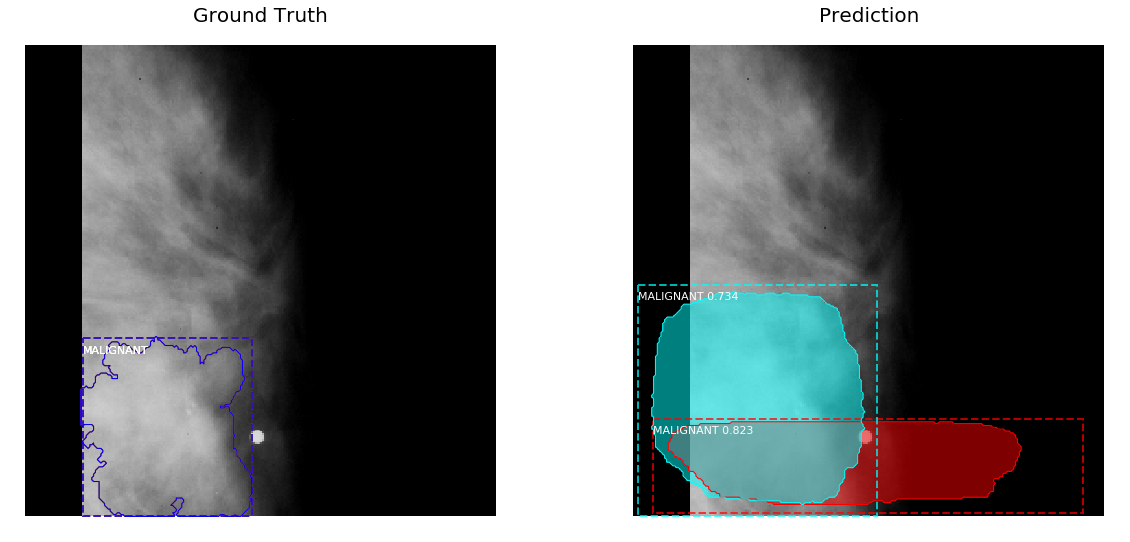

In [58]:
# Test on a random image
#image_id = random.choice(dataset_val.image_ids)
image_id = 64
print('Image id: {0}'.format(image_id))
original_image, image_meta, class_ids, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

visualize.display_instances(image = original_image,boxes = gt_bbox[:,:4],masks = gt_mask,class_ids = class_ids, 
                            class_names = dataset_val.class_names, figsize=(8, 8),ax=ax1)


print()
start =  time.time()
results = model.detect([original_image], verbose=1)
end = time.time()

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax2)

ax1.set_title('Ground Truth', fontsize=20)
ax2.set_title('Prediction',fontsize=20)

fig.subplots_adjust(hspace=50)

print('Detection time = {0} seconds'.format(end-start))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


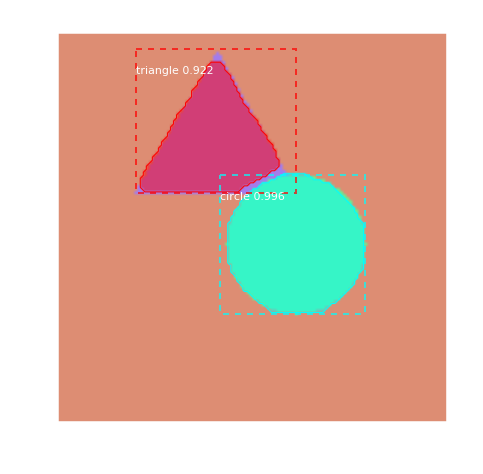

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
